In [1]:
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu0,nvcc.fastmath=True,optimizer_including=cudnn'

In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)


In [3]:
n_bands = 128
n_time = 64
nb_filters = 16
nb_row = 14
nb_col = 7
nb_pool = 2
nb_encode = 128
# dropout = 0.2
activation = 'relu'

model = Sequential()
model.add(Reshape((1, n_bands, n_time), input_shape=(n_bands, n_time)))
model.add(Convolution2D(nb_filters/2, nb_row/2, nb_col/2, activation=activation, border_mode='same'))
model.add(Convolution2D(nb_filters/2, nb_row/2, nb_col/2, activation=activation, border_mode='same'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(nb_encode, name='encoded'))
model.add(Dense(2048)) # todo: auto
model.add(Reshape((nb_filters, 16, 8)))  # todo: auto
model.add(UpSampling2D(size=(nb_pool, nb_pool)))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(UpSampling2D(size=(nb_pool, nb_pool)))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(Convolution2D(nb_filters/2, nb_row, nb_col, activation=activation, border_mode='same'))
model.add(UpSampling2D(size=(nb_pool, nb_pool)))
model.add(Convolution2D(nb_filters/2, nb_row/2, nb_col/2, activation=activation, border_mode='same'))
model.add(Convolution2D(1, nb_row/2, nb_col/2, activation=activation, border_mode='same'))
model.add(Reshape((n_bands, n_time)))
print model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 128, 64)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Reshape (reshape)             (None, 1, 128, 64)            0                   
Convolution2D (convolution2d) (None, 8, 128, 64)            176                 
Convolution2D (convolution2d) (None, 8, 128, 64)            1352                
MaxPooling2D (maxpooling2d)   (None, 8, 64, 32)             0                   
Convolution2D (convolution2d) (None, 16, 64, 32)            12560               
Convolution2D (convolution2d) (None, 16, 64, 32)            25104               
MaxPooling2D (maxpooling2d)   (None, 16, 32, 16)            0                   
Convolution2D (convolution2d) (None, 16, 32, 16)            25104       

In [4]:
%time model.compile(loss='mse', optimizer='rmsprop')

CPU times: user 52.4 s, sys: 924 ms, total: 53.3 s
Wall time: 53.7 s


In [5]:
import cPickle as pickle
with open('data/birds/fingerprints-log.pkl', 'rb') as f:
    fingerprints = pickle.load(f)

In [6]:
from numpy.random import random_integers # this is inclusive
def build_batch(data, shape):
    np.random.shuffle(data)
    X = []
    for item in data:
        if item.shape[0] < shape[0] or item.shape[1] < shape[1]:
            continue
        top = random_integers(0, item.shape[0] - shape[0])
        bottom = top + shape[0]
        left = random_integers(0, item.shape[1] - shape[1])
        right = left + shape[1]
        X.append(item[top:bottom, left:right])
    return np.array(X)

In [7]:
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

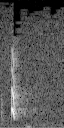

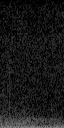

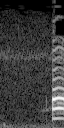

In [28]:
batch = build_batch(fingerprints, (n_bands, n_time))
for item in batch[:3]:
    showarray(item * 255)

In [9]:
history = []
try:
    for i in range(250):
        print 'Epoch %i' % i
        X = build_batch(fingerprints, (n_bands, n_time))
        cur = model.fit(X, X, verbose=2, nb_epoch=1, batch_size=64)
        history.append(cur)
except KeyboardInterrupt:
    pass

Epoch 0
Epoch 1/1
46s - loss: 53.9911
Epoch 1
Epoch 1/1
46s - loss: 0.0511
Epoch 2
Epoch 1/1
46s - loss: 0.0458
Epoch 3
Epoch 1/1
46s - loss: 0.0419
Epoch 4
Epoch 1/1
47s - loss: 0.0357
Epoch 5
Epoch 1/1
46s - loss: 0.0323
Epoch 6
Epoch 1/1
46s - loss: 0.0283
Epoch 7
Epoch 1/1
46s - loss: 0.0263
Epoch 8
Epoch 1/1
46s - loss: 0.0258
Epoch 9
Epoch 1/1
46s - loss: 0.0295
Epoch 10
Epoch 1/1
46s - loss: 0.0271
Epoch 11
Epoch 1/1
46s - loss: 0.0237
Epoch 12
Epoch 1/1
46s - loss: 0.0219
Epoch 13
Epoch 1/1
46s - loss: 0.0223
Epoch 14
Epoch 1/1
46s - loss: 0.0203
Epoch 15
Epoch 1/1
46s - loss: 0.0201
Epoch 16
Epoch 1/1
46s - loss: 0.0188
Epoch 17
Epoch 1/1
46s - loss: 0.0183
Epoch 18
Epoch 1/1
46s - loss: 0.0178
Epoch 19
Epoch 1/1
46s - loss: 0.0183
Epoch 20
Epoch 1/1
46s - loss: 0.0174
Epoch 21
Epoch 1/1
46s - loss: 0.0160
Epoch 22
Epoch 1/1
46s - loss: 0.0164
Epoch 23
Epoch 1/1
46s - loss: 0.0149
Epoch 24
Epoch 1/1
46s - loss: 0.0152
Epoch 25
Epoch 1/1
46s - loss: 0.0146
Epoch 26
Epoch 1/1
46

In [10]:
from keras import backend as K
get_encoding = K.function([model.layers[0].input], 
                          [model.layers[11].get_output(train=False)])

In [11]:
encoding = get_encoding([batch])[0]

In [12]:
from scipy.spatial.distance import pdist, squareform
distances_vector = pdist(encoding, 'cosine')
distances_matrix = squareform(distances_vector)

0.0104745079818
343053
273 984


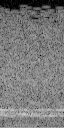

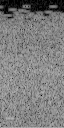

In [17]:
best = sorted(distances_vector)[np.random.randint(0,1000)]
print best
match = (distances_matrix == best).argmax()
print match
a = match / len(encoding)
b = match % len(encoding)
print a, b
showarray(batch[a]*255)
showarray(batch[b]*255)

In [18]:
predicted = model.predict(batch)

In [19]:
predicted.shape

(1253, 128, 64)

In [ ]:
for i in range(10):
    showarray(batch[i] * 255)
    showarray(predicted[i] * 255)